# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 100,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'adam',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 60,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': True,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': False,
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  285


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-1024-512-output_285_drop0e2000b256_adam/lnets_100_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_100_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:  3.2min finished
[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.0s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
83  1373158606         0.000         0.000         0.000         0.000   
53  1373158606         0.000         0.000         0.000         0.000   
70  1373158606         0.000         0.000         0.000         0.000   
45  1373158606         0.000         0.000         0.000         0.000   
44  1373158606        -0.797         0.000         0.000         0.000   

    20001-target  20000-target  12000-target  11100-target  11010-target  \
83        -0.987         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.093   
44         0.000         0.000         0.000         0.000         0.000   

    11001-target  11000-target  10200-target  10110-target  10101-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45        -0.312         0.000         0.000         0.000         0.000   
44         0.000         0.000        -0.689         0.000         0.000   

    10100-target  10020-target  10011-target  10010-target  10002-target  \
83         0.000         0.000         0.000         0.000        -0.534   
53         0.000         0.000        -0.385         0.000         0.000   
70         0.000         0.000         0.000         0.737         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    10001-target  10000-target  03000-target  02100-target  02010-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.676         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000        -0.639   

    02001-target  02000-target  01200-target  01110-target  01101-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    01100-target  01020-target  01011-target  01010-target  01002-target  \
83         0.000        -0.339         0.000         0.000         0.097   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.580         0.000         0.000         0.000   
45         0.000         0.000        -0.816         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    01001-target  01000-target  00300-target  00210-target  00201-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45        -0.219         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.305   

    00200-target  00120-target  00111-target  00110-target  00102-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.340         0.000         0.000   
70         0.000         0.000         0.000        -0.999         0.000   
45         0.000         0.000         0.000         0.000    

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  30000-target  21000-target  20100-target  20010-target  \
count        100.000       100.000       100.000       100.000       100.000   
mean  1373158606.000        -0.025         0.008         0.011        -0.018   
std            0.000         0.161         0.244         0.180         0.137   
min   1373158606.000        -0.926        -0.957        -0.999        -0.901   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         0.570         0.832         0.738         0.432   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean          0.001         0.007        -0.009         0.009        -0.025   
std           0.172         0.120         0.157         0.141         0.225   
min          -0.987        -0.519        -0.925        -0.852        -0.965   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.837         0.777         0.422         0.725         0.811   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean         -0.040        -0.017        -0.019         0.028        -0.025   
std           0.234         0.215         0.222         0.159         0.131   
min          -0.990        -0.912        -0.996        -0.494        -0.789   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.877         0.804         0.817         0.860         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean         -0.039         0.015         0.009        -0.016         0.012   
std           0.165         0.189         0.164         0.182         0.205   
min          -0.877        -0.725        -0.469        -0.775        -0.924   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.180         0.973         0.884         0.740         0.944   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean         -0.022        -0.031         0.009        -0.010        -0.034   
std           0.145         0.182         0.100         0.202         0.165   
min          -0.770        -0.988        -0.346        -0.990        -0.939   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.579         0.624         0.676         0.919         0.412   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
count       100.000       100.000       100.000       100.000       100.000   
mean         -0.017         0.011         0.008         0.011        -0.025   
std           0.147         0.220         0.159         0.179         0.174   
min          -0.698        -0.899        -0.716        -0.926        -0.988   
25%           0.000         0.000         0.000     

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.49176592, 0.28664092, 0.73558645, 0.67527019, 0.67909052],
       [0.13104553, 0.94931777, 0.17096534, 0.90397047, 0.64301633],
       [0.66117299, 0.21674007, 0.76624327, 0.70177354, 0.11621332],
       [0.54336313, 0.33835715, 0.11060129, 0.41003792, 0.88950269],
       [0.36936178, 0.01160541, 0.97988136, 0.11578048, 0.63627963],
       [0.33724654, 0.93514023, 0.23601547, 0.16221874, 0.07283645],
       [0.23524654, 0.28766858, 0.54459309, 0.82597885, 0.20780265],
       [0.7692759 , 0.40676341, 0.43188633, 0.64394346, 0.12666862],
       [0.95435648, 0.78899521, 0.26820231, 0.57831563, 0.28521901],
       [0.13451654, 0.55026487, 0.01885996, 0.00470654, 0.77155522]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.278409  ],
       [-0.22151005],
       [-0.0897447 ],
       [-0.4442662 ],
       [-0.15963447],
       [-0.01690188],
       [-0.078015  ],
       [-0.13597891],
       [-0.37569621],
       [-0.02448955]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            lambda_net_test_dataset = lambda_net_dataset #_, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 345)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 345)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 345)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
15722  1373158606         0.000         0.000         0.000         0.000   
49742  1373158606        -0.421         0.000         0.000         0.000   
15559  1373158606         0.000         0.000         0.000         0.000   
37857  1373158606         0.000         0.000         0.000         0.000   
35691  1373158606         0.000         0.000         0.000        -0.383   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
15722         0.000         0.000         0.000         0.000         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000        -0.912         0.000         0.000         0.000   
37857         0.000         0.000         0.000         0.000         0.000   
35691        -0.850         0.000         0.000         0.000         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
15722         0.000         0.000         0.000        -0.651         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000         0.681         0.000         0.000         0.000   
37857         0.000         0.000        -0.471         0.000         0.000   
35691         0.000         0.000         0.000         0.000         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
15722         0.000         0.911         0.000         0.000         0.000   
49742         0.000         0.509         0.000         0.000         0.000   
15559         0.000         0.000         0.000         0.000        -0.852   
37857         0.000        -0.842         0.000         0.000         0.000   
35691         0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
15722         0.000         0.000         0.000         0.000         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000         0.000         0.000         0.000         0.000   
37857         0.000         0.000         0.000         0.000         0.000   
35691         0.690         0.000         0.000         0.000         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
15722         0.000         0.000         0.000         0.000         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000         0.000         0.000         0.000         0.000   
37857         0.000         0.000         0.000         0.000         0.000   
35691         0.000         0.000         0.000         0.000         0.000   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
15722         0.000         0.000        -0.619         0.000         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000         0.000         0.000         0.000         0.000   
37857         0.000         0.000         0.000         0.000         0.000   
35691         0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
15722         0.000         0.000         0.000         0.000         0.000   
49742         0.000         0.000         0.000         0.000         0.000   
15559         0.000         0.000         0.000         0.000         0.000   
37857        -0.915         0.000         0.000         0.000         0.000   
35691         0.000         0.000         0.000         0.000         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
15722         0.000         0.000         0.000         0.000         0.000   
49742        -0.507        -0.591         0.000         0.000      

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
35587  1373158606         0.000         0.000         0.000         0.465   
32681  1373158606         0.550         0.000         0.000         0.000   
40971  1373158606         0.000         0.000         0.498         0.000   
21022  1373158606         0.000         0.000         0.000         0.000   
6403   1373158606         0.000         0.000         0.000         0.000   

       20001-target  20000-target  12000-target  11100-target  11010-target  \
35587         0.000         0.000         0.000         0.000         0.093   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.717         0.000        -0.995         0.000   

       11001-target  11000-target  10200-target  10110-target  10101-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.729         0.000   

       10100-target  10020-target  10011-target  10010-target  10002-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000        -0.232   
6403          0.000         0.000         0.000         0.000         0.000   

       10001-target  10000-target  03000-target  02100-target  02010-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.780        -0.139         0.000         0.000   
40971        -0.296         0.000         0.000         0.000         0.000   
21022         0.000         0.131         0.575         0.000         0.986   
6403          0.000         0.000         0.000         0.000         0.000   

       02001-target  02000-target  01200-target  01110-target  01101-target  \
35587         0.000         0.000         0.000         0.000        -0.568   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.938         0.000         0.000   
6403          0.000         0.000         0.000        -0.691         0.000   

       01100-target  01020-target  01011-target  01010-target  01002-target  \
35587         0.000         0.000         0.000         0.451         0.000   
32681         0.000         0.000         0.000         0.000         0.000   
40971         0.000         0.000         0.000         0.000        -0.046   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.000         0.000   

       01001-target  01000-target  00300-target  00210-target  00201-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.804         0.000   
40971         0.000         0.000         0.000         0.000         0.000   
21022         0.000         0.000         0.000         0.000         0.000   
6403          0.000         0.000         0.000         0.577         0.000   

       00200-target  00120-target  00111-target  00110-target  00102-target  \
35587         0.000         0.000         0.000         0.000         0.000   
32681         0.000         0.000         0.000         0.000      

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
83  1373158606         0.000         0.000         0.000         0.000   
53  1373158606         0.000         0.000         0.000         0.000   
70  1373158606         0.000         0.000         0.000         0.000   
45  1373158606         0.000         0.000         0.000         0.000   
44  1373158606        -0.797         0.000         0.000         0.000   

    20001-target  20000-target  12000-target  11100-target  11010-target  \
83        -0.987         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.093   
44         0.000         0.000         0.000         0.000         0.000   

    11001-target  11000-target  10200-target  10110-target  10101-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45        -0.312         0.000         0.000         0.000         0.000   
44         0.000         0.000        -0.689         0.000         0.000   

    10100-target  10020-target  10011-target  10010-target  10002-target  \
83         0.000         0.000         0.000         0.000        -0.534   
53         0.000         0.000        -0.385         0.000         0.000   
70         0.000         0.000         0.000         0.737         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    10001-target  10000-target  03000-target  02100-target  02010-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.676         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000        -0.639   

    02001-target  02000-target  01200-target  01110-target  01101-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    01100-target  01020-target  01011-target  01010-target  01002-target  \
83         0.000        -0.339         0.000         0.000         0.097   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.580         0.000         0.000         0.000   
45         0.000         0.000        -0.816         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.000   

    01001-target  01000-target  00300-target  00210-target  00201-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.000         0.000         0.000   
70         0.000         0.000         0.000         0.000         0.000   
45        -0.219         0.000         0.000         0.000         0.000   
44         0.000         0.000         0.000         0.000         0.305   

    00200-target  00120-target  00111-target  00110-target  00102-target  \
83         0.000         0.000         0.000         0.000         0.000   
53         0.000         0.000         0.340         0.000         0.000   
70         0.000         0.000         0.000        -0.999         0.000   
45         0.000         0.000         0.000         0.000    

## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(176,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00


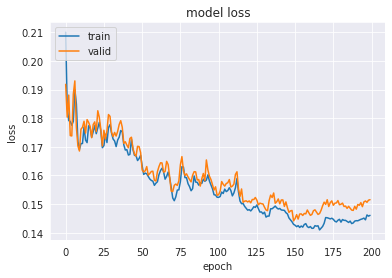

In [25]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
inet_metrics

['r2']

In [27]:
inet_loss

'mae'

In [28]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         724992      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [29]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  
runtimes_list = []

for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)
    runtimes_list.append({})
    



In [30]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred, inet_runtime = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred
    runtimes_list[i]['inet_runtime'] =  np.array([inet_runtime/len(lambda_net_test_dataset.target_polynomial_list) for _ in range(len(lambda_net_test_dataset.target_polynomial_list))])
    

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [31]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test     
        runtimes_list[i]['metamodel_poly_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [32]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       
        runtimes_list[i]['metamodel_functions_runtime'] = metamodel_runtimes
        
    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is de

Metamodel Optimization Time: 1:37:12
---------------------------------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [03:14<00:00, 19.42s/it][Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 97.2min finished


In [33]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test   
        runtimes_list[i]['metamodel_functions_no_GD_runtime'] = metamodel_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [36]:
%load_ext autoreload

In [ ]:
%autoreload 2
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test, symbolic_regression_runtimes = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test    
        runtimes_list[i]['symbolic_regression_runtime'] = symbolic_regression_runtimes

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
#%load_ext autoreload

In [ ]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

In [ ]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []
runtime_distrib_list = []
for function_values_test, polynomial_dict_test, runtimes_dict in zip(function_values_test_list, polynomial_dict_test_list, runtimes_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)
    runtimes_list.append(pd.DataFrame(runtimes_dict))

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


In [ ]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [ ]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [ ]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [ ]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [ ]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [ ]:
scores_test_list[-1]

In [95]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.088  4.936   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.303 0.431 25.459   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.088  1.625   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.306 0.432 64.652   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.303 0.431 25.459   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.600   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.186   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.600   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.174   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.186   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
metamodel_functions_VS_symbolic_regression_func...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.010   
target_polynomials_VS_metamodel_functions                           NaN   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials             

In [50]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
lambda_preds_VS_metamodel_functions                  NaN   NaN    NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.088  4.936   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.303 0.431 25.459   
target_polynomials_VS_metamodel_functions            NaN   NaN    NaN   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.088  1.625   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.306 0.432 64.652   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   NaN   NaN    NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN    NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.303 0.431 25.459   
lstsq_target_polynomials_VS_metamodel_functions      NaN   NaN    NaN   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN    NaN   
inet_polynomials_VS_metamodel_functions              NaN   NaN    NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN    NaN   
metamodel_functions_VS_symbolic_regression_func...   NaN   NaN    NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_metamodel_functions                      NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.600   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.186   
target_polynomials_VS_metamodel_functions                NaN   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.600   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.174   
lstsq_lambda_pred_polynomials_VS_metamodel_func...       NaN   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.186   
lstsq_target_polynomials_VS_metamodel_functions          NaN   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_metamodel_functions                  NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
metamodel_functions_VS_symbolic_regression_func...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_metamodel_functions                                 NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.010   
target_polynomials_VS_metamodel_functions                           NaN   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials             

In [51]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.011 0.020 0.011 0.009   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.011 0.019 0.011 0.009   
lambda_preds_VS_lstsq_target_polynomials           0.011 0.020 0.011 0.009   
lambda_preds_VS_inet_polynomials                   0.088 0.150 0.270 0.128   
lambda_preds_VS_metamodel_functions                0.698 0.399 0.693 0.787   
lambda_preds_VS_symbolic_regression_functions      0.049 0.024 0.058 0.032   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.006 0.014 0.007 0.006   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.088 0.153 0.270 0.129   
target_polynomials_VS_metamodel_functions          0.700 0.400 0.691 0.785   
target_polynomials_VS_symbolic_regression_funct... 0.048 0.020 0.057 0.031   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.006 0.014 0.007 0.006   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.089 0.150 0.269 0.128   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.699 0.400 0.693 0.786   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.049 0.019 0.057 0.029   
lstsq_target_polynomials_VS_inet_polynomials       0.088 0.153 0.270 0.129   
lstsq_target_polynomials_VS_metamodel_functions    0.700 0.400 0.691 0.785   
lstsq_target_polynomials_VS_symbolic_regression... 0.048 0.020 0.057 0.031   
inet_polynomials_VS_metamodel_functions            0.685 0.455 0.568 0.778   
inet_polynomials_VS_symbolic_regression_functions  0.071 0.153 0.278 0.144   
metamodel_functions_VS_symbolic_regression_func... 0.694 0.398 0.704 0.795   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.016 0.007 0.013 0.008   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.015 0.007 0.013 0.008   
lambda_preds_VS_lstsq_target_polynomials           0.016 0.007 0.013 0.008   
lambda_preds_VS_inet_polynomials                   0.146 0.039 0.137 0.124   
lambda_preds_VS_metamodel_functions                0.852 0.492 0.475 0.804   
lambda_preds_VS_symbolic_regression_functions      0.085 0.047 0.085 0.066   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.011 0.004 0.008 0.005   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.147 0.038 0.137 0.125   
target_polynomials_VS_metamodel_functions          0.853 0.492 0.477 0.804   
target_polynomials_VS_symbolic_regression_funct... 0.085 0.047 0.084 0.065   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.011 0.004 0.008 0.005   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.144 0.038 0.137 0.124   
lstsq_lambda_pred_polynomials_VS_metamodel_func... 0.852 0.491 0.475 0.804   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.085 0.047 0.083 0.065   
lstsq_target_polynomials_VS_inet_polynomials       0.147 0.038 0.137 0.125   
lstsq_target_polynomials_VS_metamodel_functions    0.853 0.492 0.477 0.804   
lstsq_target_polynomials_VS_symbolic_regression... 0.085 0.047 0.084 0.065   
inet_polynomials_VS_metamodel_functions            0.794 0.475 0.565 0.799   
inet_polynomials_VS_symbolic_regression_functions  0.161 0.058 0.096 0.140   
metamodel_functions_VS_symbolic_regression_func... 0.859 0.500 0.505 0.803   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.024 0.014 0.021 0.011   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.019 0.013 0.020 0.011   
lambda_preds_VS_lstsq_target_polynomials           0.024 0.014 0.021 0.011   
lambda_preds_VS_inet_polynomials                   0.206 0.142 0.213 0.086   
lambda_preds_VS_metamodel_functions                0.311 0.353 0.666 0.407   
lambda_preds_VS_symbolic_regression_functions      0.068 0.082 0.061 0.058   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.015 0.008 0.011 0.00

In [52]:
distrib_dict_test_list[-1]['R2']

L-0     L-1     L-2  \
lambda_preds_VS_target_polynomials                    0.997   0.987   0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.997   0.990   0.999   
lambda_preds_VS_lstsq_target_polynomials              0.997   0.987   0.998   
lambda_preds_VS_inet_polynomials                      0.803   0.392   0.274   
lambda_preds_VS_metamodel_functions                  -6.867  -2.132  -2.719   
lambda_preds_VS_symbolic_regression_functions         0.938   0.984   0.953   
target_polynomials_VS_lstsq_lambda_pred_polynom...    0.999   0.994   0.999   
target_polynomials_VS_lstsq_target_polynomials        1.000   1.000   1.000   
target_polynomials_VS_inet_polynomials                0.804   0.388   0.276   
target_polynomials_VS_metamodel_functions            -6.783  -1.990  -2.660   
target_polynomials_VS_symbolic_regression_funct...    0.937   0.989   0.954   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    0.999   0.993   0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials     0.804   0.389   0.276   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   -6.821  -2.155  -2.721   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    0.938   0.990   0.956   
lstsq_target_polynomials_VS_inet_polynomials          0.804   0.388   0.276   
lstsq_target_polynomials_VS_metamodel_functions      -6.783  -1.990  -2.660   
lstsq_target_polynomials_VS_symbolic_regression...    0.937   0.989   0.954   
inet_polynomials_VS_metamodel_functions              -6.750  -4.252  -8.367   
inet_polynomials_VS_symbolic_regression_functions     0.865   0.168  -2.187   
metamodel_functions_VS_symbolic_regression_func... -134.954 -49.761 -66.432   

                                                        L-3      L-4      L-5  \
lambda_preds_VS_target_polynomials                    0.998    0.996    0.994   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.999    0.997    0.995   
lambda_preds_VS_lstsq_target_polynomials              0.998    0.996    0.994   
lambda_preds_VS_inet_polynomials                      0.714    0.686    0.779   
lambda_preds_VS_metamodel_functions                  -5.634   -5.346  -16.220   
lambda_preds_VS_symbolic_regression_functions         0.981    0.897    0.765   
target_polynomials_VS_lstsq_lambda_pred_polynom...    0.999    0.998    0.998   
target_polynomials_VS_lstsq_target_polynomials        1.000    1.000    1.000   
target_polynomials_VS_inet_polynomials                0.707    0.680    0.784   
target_polynomials_VS_metamodel_functions            -5.583   -5.274  -15.845   
target_polynomials_VS_symbolic_regression_funct...    0.982    0.897    0.763   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...    0.999    0.998    0.998   
lstsq_lambda_pred_polynomials_VS_inet_polynomials     0.714    0.693    0.784   
lstsq_lambda_pred_polynomials_VS_metamodel_func...   -5.602   -5.305  -16.205   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...    0.983    0.897    0.767   
lstsq_target_polynomials_VS_inet_polynomials          0.707    0.680    0.784   
lstsq_target_polynomials_VS_metamodel_functions      -5.583   -5.274  -15.845   
lstsq_target_polynomials_VS_symbolic_regression...    0.982    0.897    0.763   
inet_polynomials_VS_metamodel_functions              -9.579   -4.309  -22.980   
inet_polynomials_VS_symbolic_regression_functions     0.364    0.644    0.335   
metamodel_functions_VS_symbolic_regression_func... -119.663 -118.427 -284.907   

                                                        L-6      L-7     L-8  \
lambda_preds_VS_target_polynomials                    0.992    0.996   0.981   
lambda_preds_VS_lstsq_lambda_pred_polynomials         0.992    0.997   0.989   
lambda_preds_VS_lstsq_target_polynomials              0.992    0.996   0.981   
lambda_preds_VS_inet_polynomials                      0.155    0.345  -0.349   
lambda_preds_VS_metamodel_functions                  -5.271  -16.419  -1.282   
lambda_preds_VS_symbolic_regression_functions         

In [53]:
runtimes_list[-1].values

array([[2.73508787e-03, 1.00587105e+03, 1.22963741e+02],
       [2.73508787e-03, 1.10932128e+03, 5.49984722e+02],
       [2.73508787e-03, 1.04315790e+03, 2.30525192e+02],
       [2.73508787e-03, 1.00826370e+03, 2.16189734e+02],
       [2.73508787e-03, 9.99313411e+02, 1.09965093e+02],
       [2.73508787e-03, 1.03050390e+03, 1.13677181e+02],
       [2.73508787e-03, 1.06769295e+03, 1.33247513e+02],
       [2.73508787e-03, 1.01167570e+03, 2.34699527e+02],
       [2.73508787e-03, 1.09872735e+03, 5.15146068e+02],
       [2.73508787e-03, 1.13221097e+03, 1.40817614e+02],
       [2.73508787e-03, 9.85624970e+02, 6.49648947e+02],
       [2.73508787e-03, 1.09098118e+03, 1.08041723e+02],
       [2.73508787e-03, 1.02735433e+03, 3.89393865e+02],
       [2.73508787e-03, 2.74302747e+03, 5.37273031e+02],
       [2.73508787e-03, 1.03556410e+03, 4.00795788e+02],
       [2.73508787e-03, 1.07012710e+03, 2.65646067e+02],
       [2.73508787e-03, 1.05993758e+03, 2.08653072e+02],
       [2.73508787e-03, 1.03431

In [ ]:
paths_dict = generate_paths(path_type = 'interpretation_net_no_noise')

path_mae = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/mae_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_r2 = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/r2_distrib_test_data_' + 'noise' + str(noise) + '.csv'
path_runtimes = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/runtimes_' + 'noise' + str(noise) + '.csv'
path_fv = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/fvs_' + 'noise' + str(noise) + '.csv'
path_functions = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/functions_' + 'noise' + str(noise) + '.csv'


distrib_dict_test_list[-1]['MAE'].to_csv(path_mae)
distrib_dict_test_list[-1]['R2'].to_csv(path_r2)
runtimes_list[-1].to_csv(path_runtimes)

with open(path_fv, 'wb') as f:
    pickle.dump(function_values_test_list[-1], f, protocol=2)

with open(path_functions, 'wb') as f:
    pickle.dump(polynomial_dict_test_list[-1], f, protocol=2)


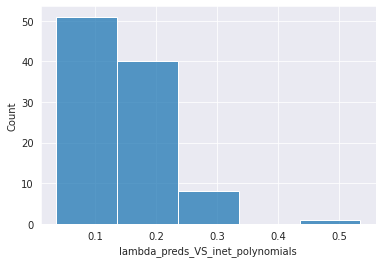

In [55]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

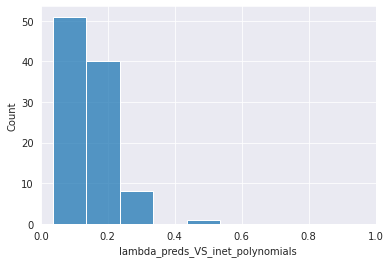

In [56]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


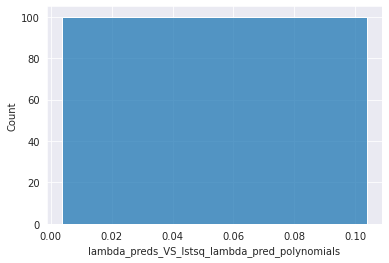

In [57]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

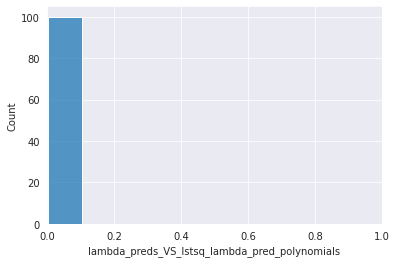

In [58]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


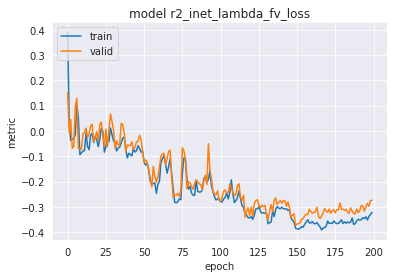

In [59]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


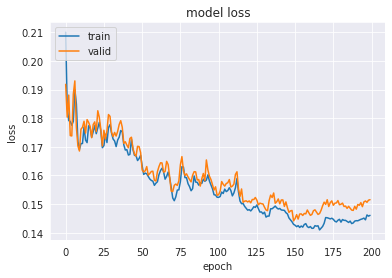

In [60]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [61]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [62]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [63]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [96]:
index = 24

custom_representation_keys_fixed = ['target_polynomials']#['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions', 'symbolic_regression_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    if key in custom_representation_keys_fixed:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)        
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in sympy_representation_keys:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        display(polynomial_dict_test_list[-1][key][index])
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
    else:
        pass

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.0523*a*b*c + 0.1469*b**2*c + 0.5145*b*c**2 - 0.1163*c - 0.1637*d*e**2

MAE:  0.0059556975
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.476500004529953*b**2*c + 0.0516000017523766*b**2*e + 0.0261000003665686*b*e**2 + 0.0366999991238117*b*e - 0.272599995136261*d*e

MAE:  0.03543023
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
metamodel_functions


1/(1.02283039845041*exp(0.000945622912390474*X0**3*X1**3 - 0.0042241481735247*X0**3*X2**3 + 0.00504050672138606*X0**3*X3**3 + 0.00454032125918424*X0**3*X4**3 + 0.0018806300253198*X0**3 - 0.000483562015905077*X0**2*X1**2 + 0.0021065156383649*X0**2*X2**2 - 0.00214864010624914*X0**2*X3**2 - 0.00188150506637854*X0**2*X4**2 + 0.0392707743868668*X0**2 - 0.0099020912706257*X0*X1 + 0.0445088114443561*X0*X2 - 0.0549918774645307*X0*X3 - 0.0498140695048201*X0*X4 - 0.00351409357456133*X0 + 0.0593914080772*X1**3*X2**3 - 9.82146966802394e-5*X1**3*X3**3 - 2.89621359564835e-5*X1**3*X4**3 + 0.00185367171706046*X1**3 - 0.0387643368362151*X1**2*X2**2 + 4.88651574464032e-5*X1**2*X3**2 + 1.402279429176e-5*X1**2*X4**2 + 0.0410304182763013*X1**2 - 0.578685490394375*X1*X2 + 0.00103543223294629*X1*X3 + 0.000307333882976451*X1*X4 - 0.00363705888109352*X1 - 0.00547429758359434*X2**3*X3**3 - 0.0045979464328329*X2**3*X4**3 + 0.000280909419537762*X2**3 + 0.00269175517981946*X2**2*X3**2 + 0.00218696611271564*X2**2*X

MAE:  0.4813464
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


X1**2*X2**2*(X1*X2 + 0.086)*(X1**5*X2**3*(X1*X2 + 0.086)*(X1**4*X2**2*(0.402*X1 + 0.242808) - 1)*(-X2*(X3 + X4)*(X1**4*X2**4*(X1 + 0.604)*(X1*X2 + 0.086)**2*(-X1**6*X2**3*(X1*X2 + 0.086)**2*(0.402*X1*X2**2 + 0.242808) + 1) - 1) + 1) + 1)

MAE:  0.036882255
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


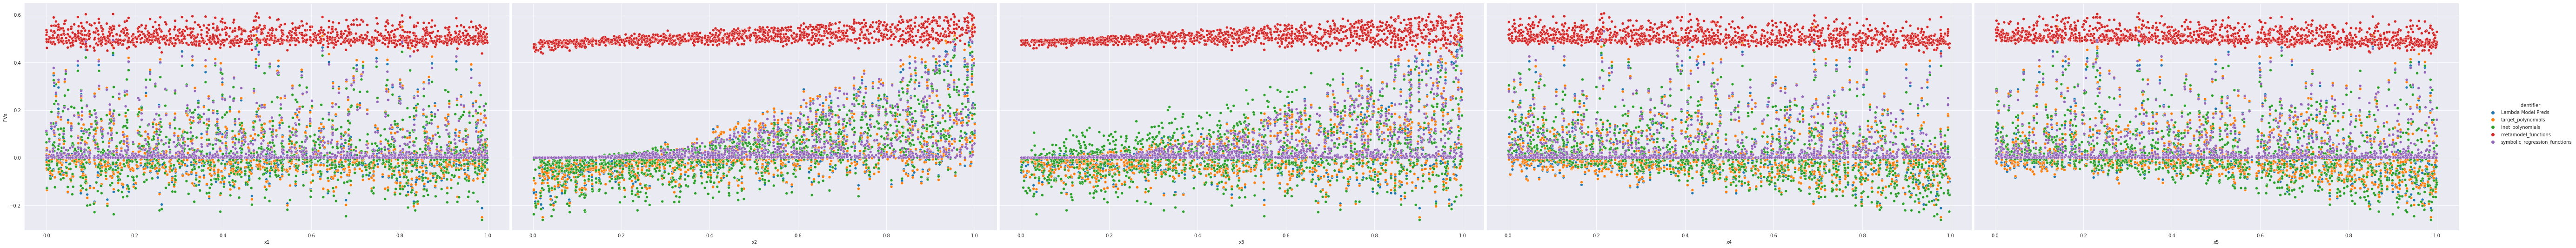

In [101]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

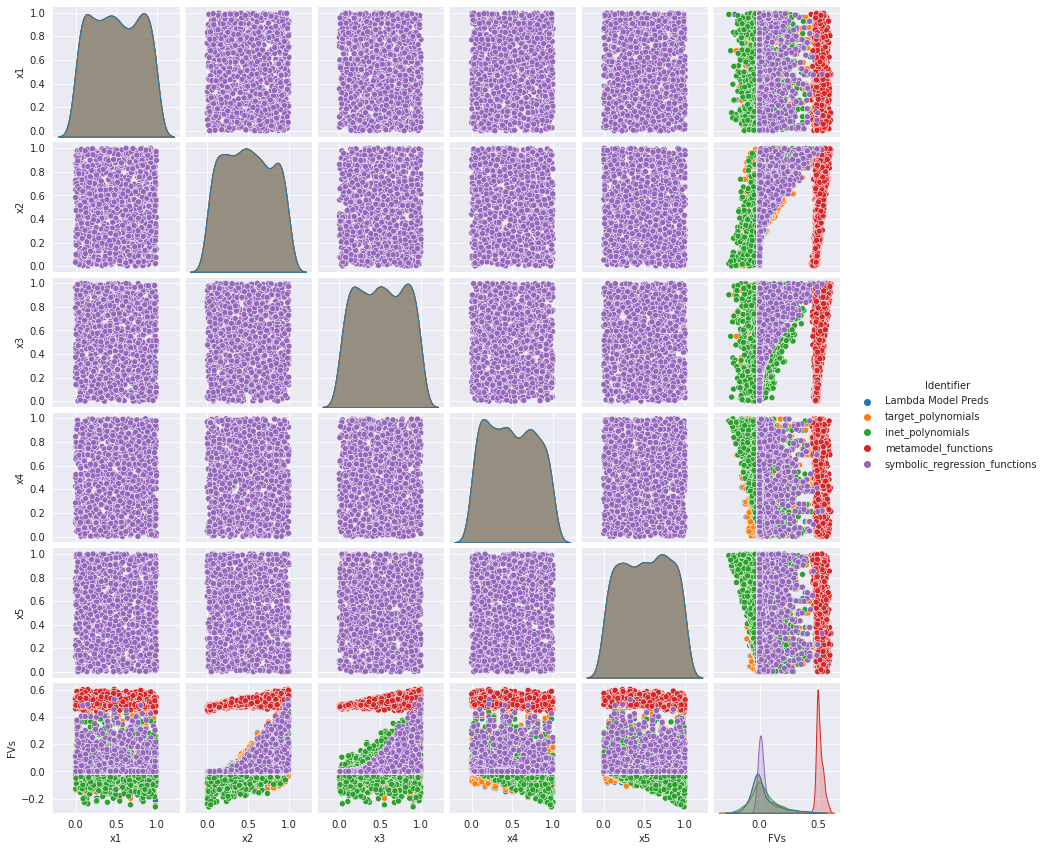

In [102]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

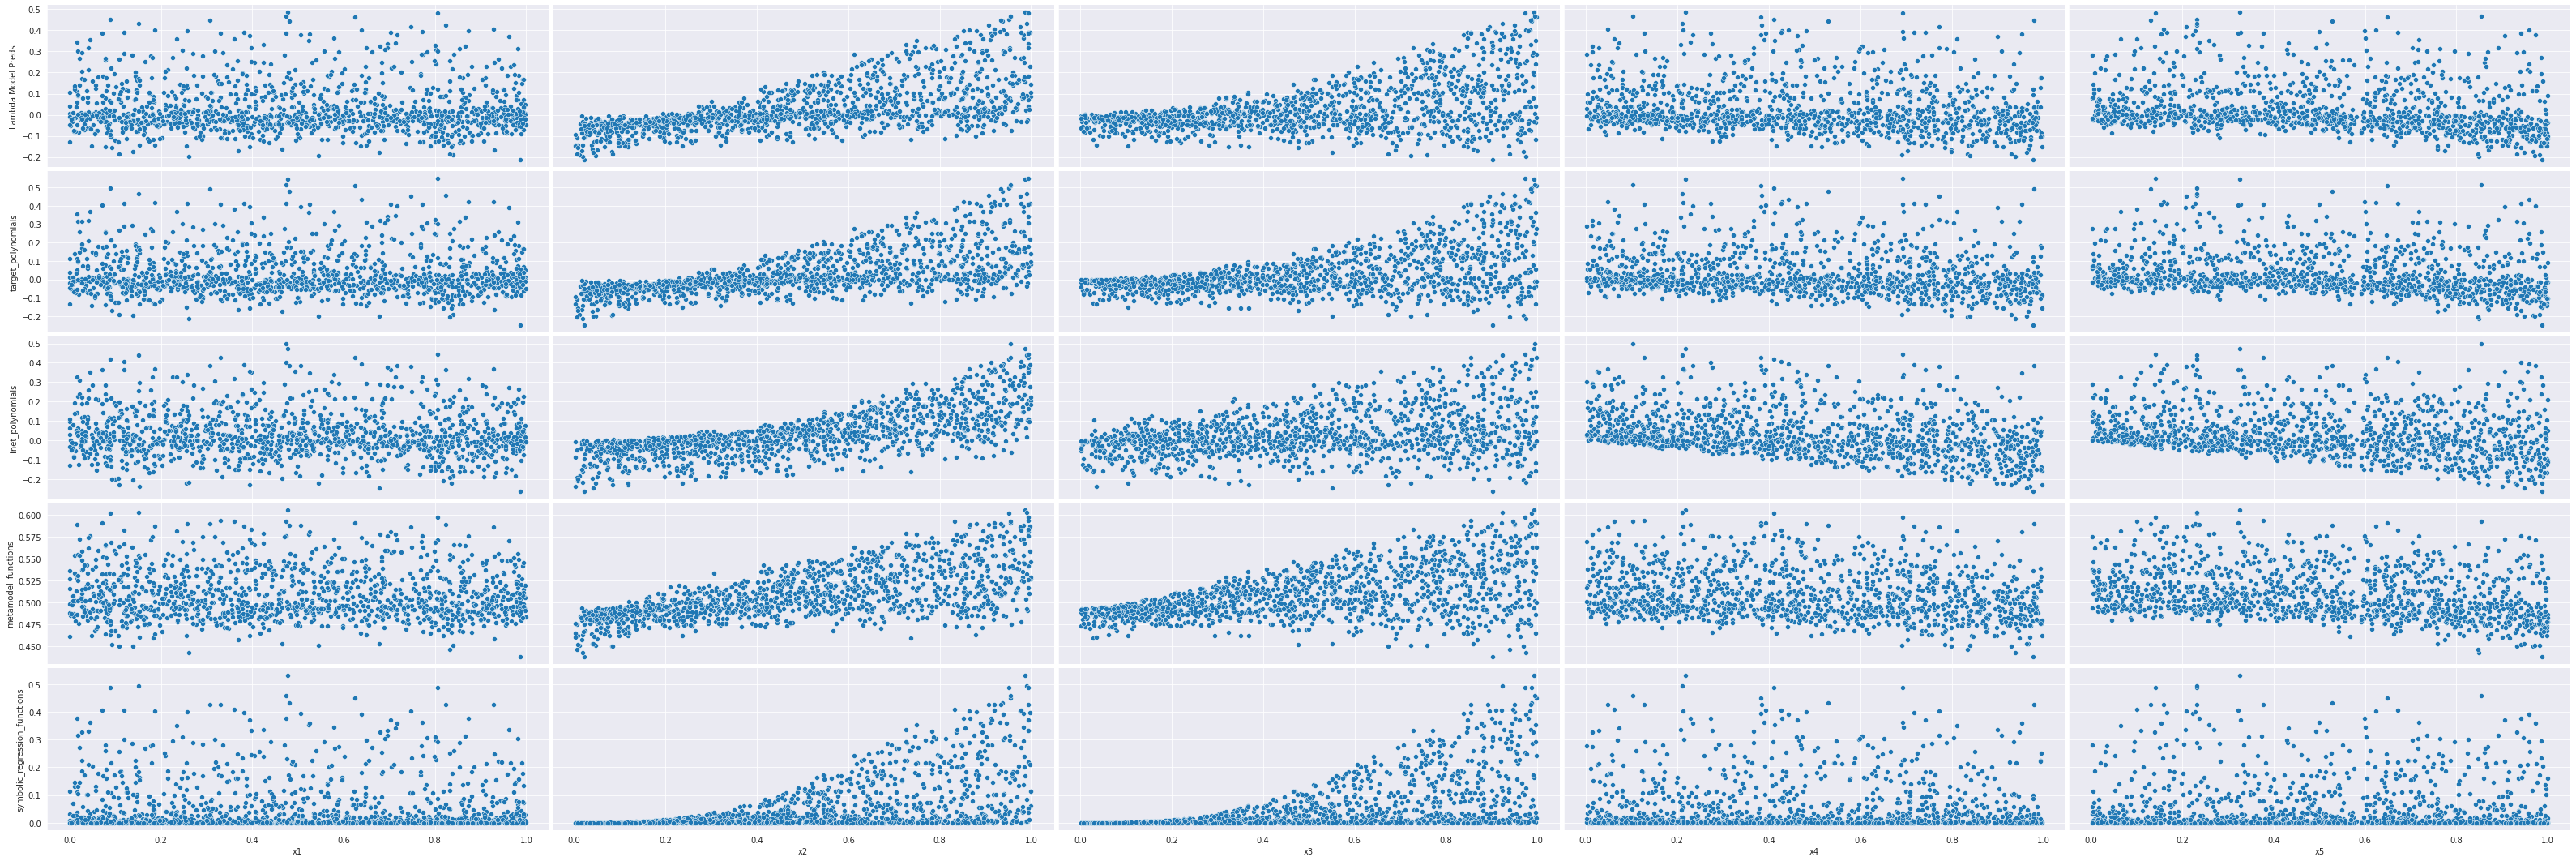

In [103]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [104]:
runtimes_list[-1].values

array([[2.73508787e-03, 1.00587105e+03, 1.22878574e+02],
       [2.73508787e-03, 1.10932128e+03,            nan],
       [2.73508787e-03, 1.04315790e+03,            nan],
       [2.73508787e-03, 1.00826370e+03, 2.27725909e+02],
       [2.73508787e-03, 9.99313411e+02, 1.38805279e+02],
       [2.73508787e-03, 1.03050390e+03, 1.08131168e+02],
       [2.73508787e-03, 1.06769295e+03, 1.18823093e+02],
       [2.73508787e-03, 1.01167570e+03, 2.29858257e+02],
       [2.73508787e-03, 1.09872735e+03, 1.50338950e+02],
       [2.73508787e-03, 1.13221097e+03, 1.40819736e+02],
       [2.73508787e-03, 9.85624970e+02, 2.32759357e+02],
       [2.73508787e-03, 1.09098118e+03, 1.17176192e+02],
       [2.73508787e-03, 1.02735433e+03, 2.57438057e+02],
       [2.73508787e-03, 2.74302747e+03, 1.27110312e+02],
       [2.73508787e-03, 1.03556410e+03, 1.17226708e+02],
       [2.73508787e-03, 1.07012710e+03,            nan],
       [2.73508787e-03, 1.05993758e+03,            nan],
       [2.73508787e-03, 1.03431

In [105]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.08810546, 0.1501757 , 0.2700043 , 0.12771317, 0.14647362,
       0.03913863, 0.13717574, 0.12436506, 0.20558953, 0.14193021,
       0.21345586, 0.08619374, 0.10064963, 0.13405795, 0.07916157,
       0.10627417, 0.20727588, 0.16375679, 0.0434536 , 0.279522  ,
       0.03964474, 0.15802054, 0.05974424, 0.14964646, 0.03543023,
       0.13075359, 0.08263976, 0.13742685, 0.13657092, 0.21824501,
       0.19102907, 0.07979021, 0.14714012, 0.1288562 , 0.09771346,
       0.24589616, 0.12346414, 0.1641061 , 0.05345226, 0.12799865,
       0.09091796, 0.18770134, 0.10956948, 0.08667824, 0.09880369,
       0.20067036, 0.12709309, 0.15230592, 0.17523693, 0.06261321,
       0.17788233, 0.06158442, 0.14064218, 0.07400467, 0.04476283,
       0.18497477, 0.242696  , 0.15095899, 0.09850042, 0.15635242,
       0.09874132, 0.20418195, 0.08345551, 0.11522099, 0.15085351,
       0.11868121, 0.22501875, 0.10483694, 0.05155044, 0.15379155,
       0.04893803, 0.3103288 , 0.17915139, 0.10501196, 0.07051

In [106]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_symbolic_regression_functions'].values

array([0.04867522,        nan,        nan, 0.03191228, 0.08523325,
       0.0470432 , 0.08482416, 0.04346615, 0.10046196, 0.08113532,
       0.07921011, 0.05800308, 0.07329624, 0.06138951, 0.07649968,
              nan,        nan,        nan, 0.06643128, 0.09882695,
       0.02826563, 0.05626161, 0.03434549, 0.05057149, 0.03688226,
              nan, 0.05578104, 0.06712508, 0.08792491, 0.06516483,
       0.09860787, 0.04975265, 0.02875515,        nan, 0.06633939,
              nan, 0.07372475, 0.06305268,        nan, 0.08268365,
       0.03689463, 0.07595649, 0.06274281, 0.05478208, 0.0436851 ,
       0.11377596, 0.08213616, 0.07916904, 0.11172169, 0.06866457,
       0.09312931, 0.01263718, 0.07297134, 0.04369259, 0.04411604,
       0.03893396, 0.12043174, 0.07624478,        nan,        nan,
       0.03892109,        nan,        nan, 0.03701348, 0.06499988,
              nan,        nan,        nan,        nan, 0.08972967,
       0.04144841,        nan,        nan, 0.04383431, 0.03171

In [107]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_metamodel_functions'].values

array([0.69814557, 0.3990288 , 0.69317997, 0.7867983 , 0.8518903 ,
       0.49169862, 0.474621  , 0.8039788 , 0.31078133, 0.35330015,
       0.66579396, 0.4071263 , 0.9789672 , 0.22014096, 0.5260216 ,
       0.24425887, 0.48612353, 0.6987009 , 1.2105519 , 0.5129947 ,
       0.37534145, 0.96041095, 0.7995076 , 0.5871241 , 0.4813464 ,
       0.53456014, 0.39630607, 0.5197123 , 0.8026023 , 0.6383304 ,
       1.0568813 , 0.71018064, 0.23483647, 0.3191524 , 0.7065166 ,
       0.33172774, 0.38305518, 0.19791563, 0.5818974 , 0.882801  ,
       0.5155578 , 0.34885028, 0.5364649 , 0.7603421 , 0.75701106,
       0.59259504, 0.48294747, 1.0059084 , 0.4651442 , 0.57186836,
       0.94229436, 0.55355465, 0.47643957, 0.6794256 , 0.50281554,
              nan, 0.46554136, 0.40392047, 0.76864284, 0.18354635,
       0.4732501 , 0.41051006, 0.56815726, 0.24729112, 0.62142795,
       0.25659844, 0.38951817, 0.2784367 , 0.4380081 , 0.5792999 ,
       0.65949667, 0.43907812, 0.23011035, 0.46890107, 0.33814

In [108]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([ 8.03148025e-01,  3.92163756e-01,  2.74014199e-01,  7.13830885e-01,
        6.85984040e-01,  7.78556422e-01,  1.55065383e-01,  3.44999370e-01,
       -3.49324428e-01,  7.97515533e-01,  2.29974856e-01,  4.95101508e-01,
        8.79324118e-01,  7.11735475e-01,  6.00031622e-01,  7.21220130e-01,
        4.81166916e-02,  5.72959847e-01,  6.61148576e-01,  4.43935713e-01,
        9.34756867e-01,  7.78037554e-01,  9.42264689e-01,  4.36708040e-02,
        8.45956129e-01,  5.17230796e-01,  4.86977789e-01,  1.09237381e-01,
        6.84329362e-01,  2.02724405e-01,  5.46661267e-01,  8.54920353e-01,
        5.14545074e-01,  4.94453827e-01,  5.21530554e-01,  1.84500814e-01,
        1.04115866e-01,  3.95406336e-01,  2.89068204e-01,  5.63885712e-01,
        4.00631933e-01,  4.23101963e-01,  9.33874049e-01,  8.16358969e-01,
        5.40587054e-01,  6.75247045e-01,  3.50354480e-01,  7.80709114e-01,
       -4.18532435e-02,  7.00335265e-01,  6.46730274e-01,  5.13472082e-01,
        2.39016288e-01,  

In [109]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_symbolic_regression_functions'].values

array([ 0.93824554,         nan,         nan,  0.9807497 ,  0.89659063,
        0.76455968,  0.6274444 ,  0.8960895 ,  0.68276204,  0.92552912,
        0.87832746,  0.78720247,  0.9054178 ,  0.94676795,  0.61252837,
               nan,         nan,         nan, -0.07926119,  0.92604518,
        0.96563431,  0.96477659,  0.97933279,  0.84322393,  0.80036168,
               nan,  0.78337028,  0.78978655,  0.82352655,  0.90860928,
        0.86974676,  0.94429376,  0.97179524,         nan,  0.79131064,
               nan,  0.57415429,  0.88770176,         nan,  0.76328285,
        0.89310427,  0.89689167,  0.97133773,  0.9215768 ,  0.90025473,
        0.88846381,  0.68438751,  0.94263397,  0.56773692,  0.64979825,
        0.90311426,  0.97865881,  0.75494862,  0.92216277,  0.6712556 ,
        0.2868522 ,  0.83849464,  0.82612428,         nan,         nan,
        0.83600333,         nan,         nan,  0.95455188,  0.89296941,
               nan,         nan,         nan,         nan,  0.75

In [110]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_metamodel_functions'].values

array([-6.86685462e+00, -2.13218054e+00, -2.71895856e+00, -5.63427419e+00,
       -5.34557175e+00, -1.62198680e+01, -5.27073945e+00, -1.64190131e+01,
       -1.28178915e+00, -2.30069866e-02, -4.19918755e+00, -4.48905669e+00,
       -6.38180126e+00,  3.62401189e-01, -9.10709948e+00, -1.55731686e-01,
       -3.21620858e+00, -4.36491532e+00, -1.67539031e+02, -9.87904700e-01,
       -2.99560192e+00, -5.01012908e+00, -6.30366721e+00, -7.72729159e+00,
       -1.72164765e+01, -4.67458932e+00, -5.60619529e+00, -6.31581805e+00,
       -5.99012401e+00, -3.81865040e+00, -8.58157387e+00, -6.58540278e+00,
        1.03787100e-02, -9.43221025e-01, -1.38288305e+01, -4.49341055e-01,
       -4.57686942e+00,  2.19323248e-01, -5.11136066e+01, -1.14294292e+01,
       -1.13860706e+01, -4.89097837e-01, -2.08038504e-01, -8.13737651e+00,
       -1.68572687e+01, -1.31847116e+00, -5.21722777e+00, -4.72578439e+00,
       -3.65883485e+00, -1.26028968e+01, -5.10574580e+00, -2.35093129e+01,
       -5.80971526e+00, -

In [111]:
STOP

NameError: name 'STOP' is not defined

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()